# Code for the implementation of task MNist

### importing libraries

In [6]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from keras.datasets import mnist

In [7]:
class Dataset:
    def __init__(self, train_X, train_y, test_X, test_y):
        data = {"training": {"targets": [], "features":[]}, "testing": {"targets": [], "features":[]}}
                    
        data["training"]["features"] = train_X
        data["training"]["targets"] = train_y
        data["testing"]["features"] = test_X
        data["testing"]["targets"]  = test_y
        
        self.data = data
        self.DESCR = "MNISK dataset"
        self.n_training = 60000
        self.n_testing = 10000
        self.cluster_size = 1000
        self.n_clusters = self.n_training//self.cluster_size
        self.classes_names = ['0','1','2','3','4','5','6','7','8','9']


In [9]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1] * train_X.shape[2]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1] * test_X.shape[2]))
MNISK_Dataset = Dataset(train_X, train_y, test_X, test_y)


2023-04-25 13:40:55.148021: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-25 13:40:55.178516: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-25 13:40:55.333971: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-25 13:40:55.336733: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 13:40:56.398930: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

11490434/11490434 [==============================] - 3s 0us/step


In [10]:
def NN_predict(images_predict, n_clusters, cluster_size, train_set):
    predicted = []
    for image in images_predict:
        min_dict = {"indices": [], "values": []}
        for i in range(n_clusters):
            reduced_test_set = train_set["features"][i*cluster_size:(i+1)*cluster_size]
            distances = np.ravel(cdist([image], reduced_test_set, metric='euclidean'))
            min_cluster_index = np.argmin(distances)
            min_global_index = i*cluster_size+min_cluster_index
            min_dict["indices"].append(min_global_index)
            min_dict["values"].append(distances[min_cluster_index])
        min_dict_NN_index = np.argmin(min_dict["values"])
        NN_global_index = min_dict["indices"][min_dict_NN_index]
        predicted.append(train_set["targets"][NN_global_index])
    return predicted

## Confusion matrix for test set

In [37]:
def PlotConfusionMatrix(matrix):
    fig, ax = plt.subplots(figsize=(16, 8))
    metrics.ConfusionMatrixDisplay(confusion_matrix=matrix, 
                                   display_labels=MNISK_Dataset.classes_names,
                                   ).plot(cmap="Blues", ax=ax)
    plt.title("NN classifier test-set")
    plt.tight_layout()
    plt.show()

In [32]:
def conf_matrix_test(MNISK_Dataset: Dataset):
    n_classes = 10
    data = MNISK_Dataset.data
    conf_matrix = np.zeros((n_classes, n_classes)).astype(int)
    testing_data = data["testing"]["features"][0:500]
    prediction = NN_predict(testing_data, MNISK_Dataset.n_clusters, MNISK_Dataset.cluster_size, data["training"])
    n_misclassified = 0
    misclassified_examples = []
    correctly_classified_examples = []
    for i in range(len(prediction)):
        target = data["testing"]["targets"][i]
        pred = prediction[i]
        conf_matrix[target, pred] += 1
        # extracting four examples of misclassified and four examples of correctly classified images for later 
        if target != pred and len(misclassified_examples) < 4:
            n_misclassified += 1
            misclassified_examples.append([testing_data[i], pred, target])
        elif target == pred and len(correctly_classified_examples) < 4:
            correctly_classified_examples.append([testing_data[i], pred, target])


    error_rate = n_misclassified / len(testing_data)
    return conf_matrix, error_rate, misclassified_examples, correctly_classified_examples 

Error rate: 0.008


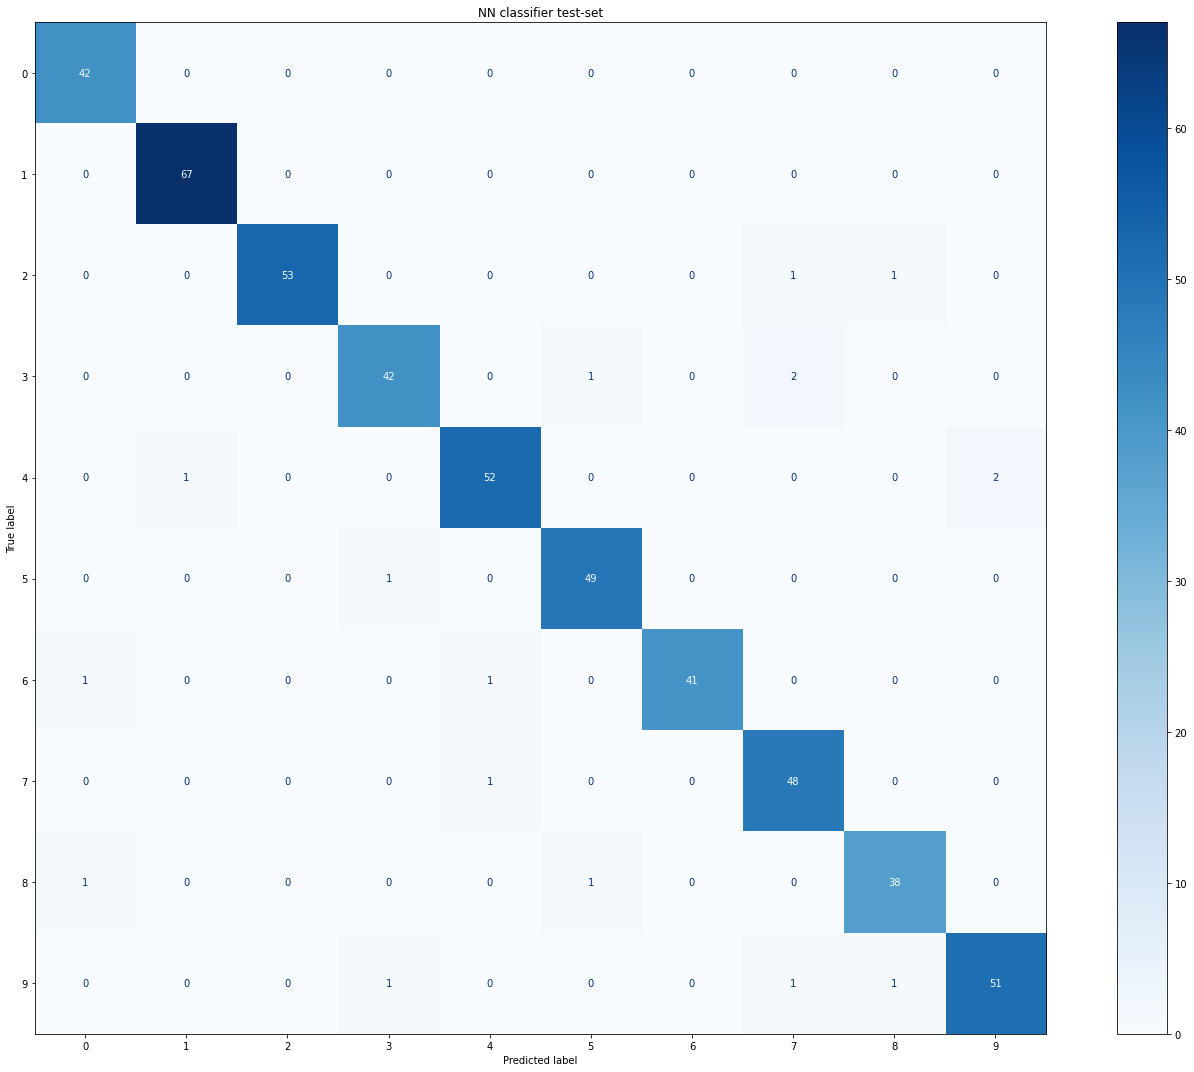

In [35]:
confusion_matrix, error_rate, misclassified_examples, correctly_classified_examples = conf_matrix_test(MNISK_Dataset)

Error rate: 0.008


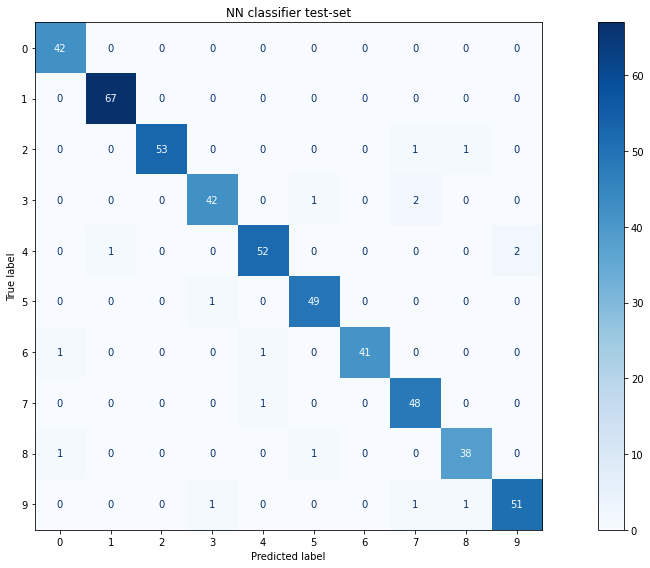

In [38]:
print("Error rate: " + str(error_rate))
PlotConfusionMatrix(confusion_matrix)

## 1b) Plot some examples

In [25]:
def PlotExamples(examples):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for i, (image, predicted, target) in enumerate(examples):
        ax = axs[i//2, i%2]
        ax.set_title(f"Classified as {predicted}, target is {target}")
        ax.imshow(np.reshape(image, (28, 28)), cmap='gray')

    fig.subplots_adjust(hspace=0.4)

    plt.show()

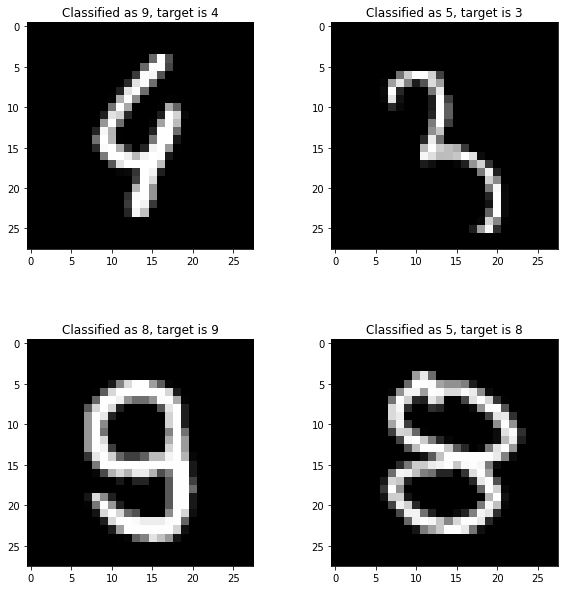

In [28]:
PlotExamples(misclassified_examples)


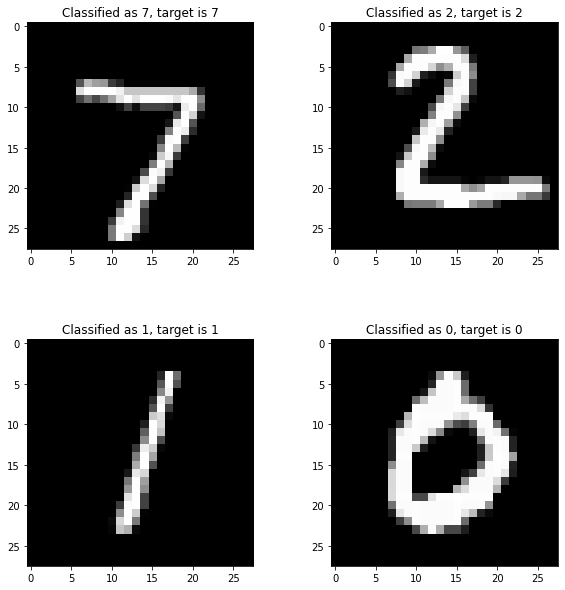

In [27]:
PlotExamples(correctly_classified_examples)

There is not too much to say about the correctly classified examples. They all seem to be pretty easy to handle for the classifier. As for the misclassified examples, there were some somewhat strange results. As humans, it is hard to understand why the image with the number eight was classified as a five, although one can see the contour of parts of a five if one uses ones imagination. It is also a little bit hard to see how the image with the number three can be classified as a five, but also here it is possible to see how the classifier got it wrong. One can see something resembling the lower part of a five, and it is not a very pretty number three. The two other misclassification examples makes more sense in our opinion, even though it is easy for us as humans to see what they should be.  